In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# for nicer plots
import seaborn as sns
sns.set()

# LUT training -- Lanzhot -- analysis of bands
- **Goal:** Train a simple ML model on LUT data (Lanzhot), analyze the importance of individual bands
- **Table of Contents:**
    - [1. Load data](#1.-Load-data)
    - [2. Data analysis](#2.-Data-analysis)
    - [3. Modelling](#3.-Modelling)
- **Author:**: T. Slanináková, `xslanin@fi.muni.cz`
- **Date:**: 2023-03-28

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

## 1. Load data

In [60]:
base_data_path = '/storage/brno11-elixir/home/tslaninakova/enviro-nn/data'
base_path = f'{base_data_path}/raw-input-data/Lanzhot'
lut = pd.read_csv(f'{base_path}/lut.csv')
lut.columns = [float(c) for c in lut.columns]
lut_params = pd.read_csv(f'{base_path}/params.csv')
lut.head(2)

In [61]:
lut_params.head(2)

406.3     415.8     425.3     434.8     444.3     453.8     463.3   \
0  0.010654  0.011317  0.011961  0.012367  0.012936  0.014111  0.015349   
1  0.009629  0.010099  0.010608  0.010924  0.011477  0.012702  0.013969   
2  0.010672  0.011029  0.011495  0.011785  0.012415  0.013874  0.015363   
3  0.010355  0.010753  0.011203  0.011482  0.011961  0.013023  0.014134   
4  0.008904  0.009289  0.009703  0.009958  0.010321  0.011091  0.011908   

     472.7     482.2     491.7   ...   955.5    965.0    974.5    984.0   \
0  0.016134  0.016918  0.019359  ...  0.33258  0.33313  0.33485  0.33741   
1  0.014731  0.015546  0.018241  ...  0.36780  0.36520  0.36527  0.36664   
2  0.016236  0.017194  0.020362  ...  0.36748  0.36607  0.36672  0.36847   
3  0.014816  0.015541  0.017920  ...  0.36067  0.36028  0.36154  0.36382   
4  0.012423  0.012963  0.014771  ...  0.39572  0.39374  0.39403  0.39545   

    993.5    1003.0   1012.6   1022.1   1031.6   1041.1  
0  0.34057  0.34548  0.34995  0.35380  0.35781  0.36187  
1  0.36893  0.37216  0.37549  0.37870  0.38179  0.38456  
2  0.37102  0.37475  0.37839  0.38175  0.38509  0.38825  
3  0.36683  0.37139  0.37568  0.37948  0.38336  0.38720  
4  0.39770  0.40089  0.40411  0.40715  0.41012  0.41283  

[5 rows x 68 columns]

## 2. Data analysis -- feature importances
**Goal:** Find out which bands influence the prediction quality of the target variable.
    - does that translate to the usable wavelength recommendation per parameter?


**Wavelength recommendation:** (copied from `LUT-reduction.docx`):

| Parameter | Wavelenth range |
| --- | --- |
| Cab | 400–750 |
| Car | 400–750 |
| Cw, Cm | 750–2300 |

In [44]:
X_train, X_test, y_train, y_test = train_test_split(lut, params['Cab'].values, test_size=0.05, random_state=42)
X_train.shape, X_test.shape

## 3. Modelling
**Goal**: Scale features with MinMax, train a RF (100 trees by default), visualize the feature importances.

In [41]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
p = make_pipeline(MinMaxScaler(), RandomForestRegressor())

In [42]:
p_fitted = p.fit(X_train, y_train)
forest = p_fitted[1]

Elapsed time to compute the importances for Cab: 15.211 seconds
Elapsed time to compute the importances for Car: 15.521 seconds
Elapsed time to compute the importances for Cm: 15.179 seconds
Elapsed time to compute the importances for Cw: 14.828 seconds


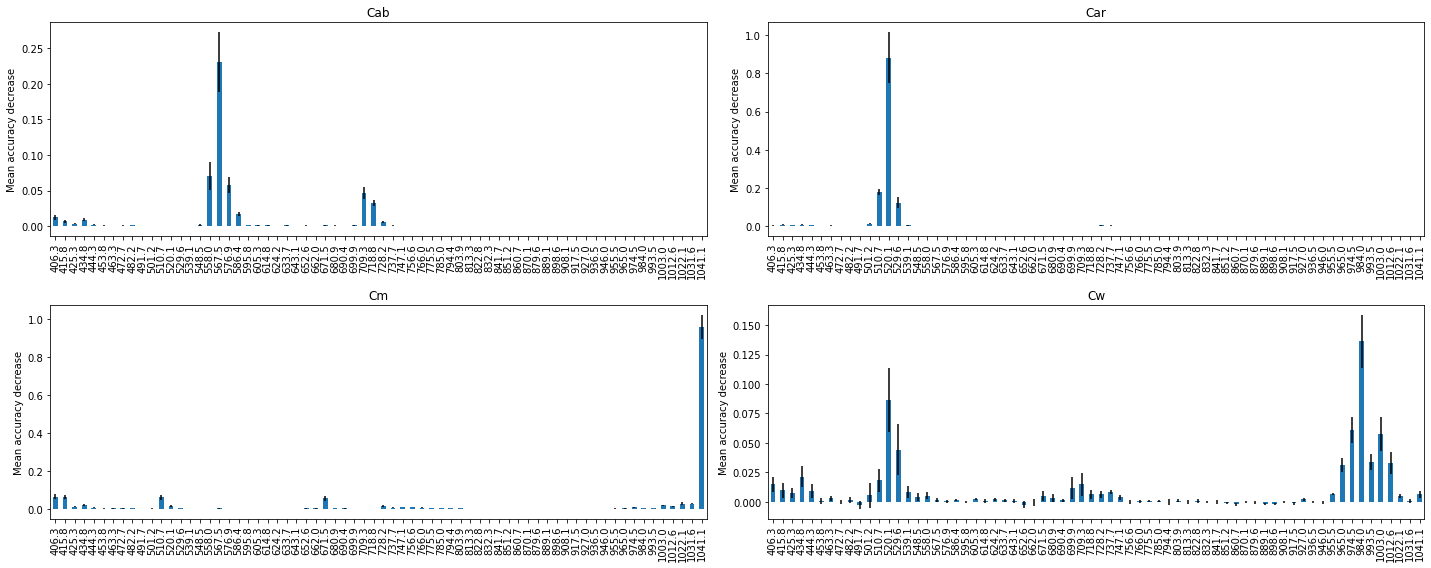

In [50]:
import time

fig, axs = plt.subplots(2, 2, figsize=(20, 8))

for param, ax in zip(['Cab', 'Car', 'Cm', 'Cw'], axs.flatten()):
    X_train, X_test, y_train, y_test = train_test_split(
        lut, params[param].values, test_size=0.05, random_state=42
    )
    p = make_pipeline(MinMaxScaler(), RandomForestRegressor())
    p_fitted = p.fit(X_train, y_train)
    forest = p_fitted[1]
    
    start_time = time.time()
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances for {param}: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(param)
    ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

> The recommendation does hold for all parameters, though for `Cw` (and `Cm` a bit) the lower wls seem to be important (as opposed to >750 recommended)